---

<h1 style="text-align: center;font-size: 40px;">Face Mask Detection using MobileNet & OpenCV</h1>

---

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
import cv2
import random


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My\ Drive/mask_detection/

/content/drive/My Drive/mask_detection


In [ ]:
ls

 face_mask1.h5         haarcascade_frontalface_default.xml
'Face Mask Dataset'/   moblenet_facemask.h5
 face_mask.h5


In [ ]:
os.listdir("Face Mask Dataset/Train/")

['WithMask', 'WithoutMask']

In [ ]:
print("Images in Train Dataset:\n")
print("Number of Images for with Mask category:{}".format(len(os.listdir("Face Mask Dataset/Train/WithMask"))))
print("Number of Images for with WithoutMask category:{}".format(len(os.listdir("Face Mask Dataset/Train/WithoutMask/"))))


Images in Train Dataset:

Number of Images for with Mask category:5000
Number of Images for with WithoutMask category:5002


In [ ]:
train_dir = "Face Mask Dataset/Train/"
test_dir = "Face Mask Dataset/Test/"

><h3>Images:</h3>

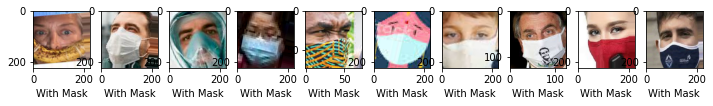

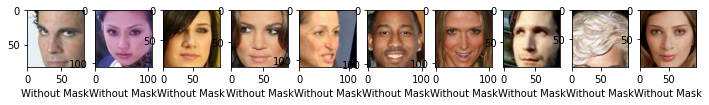

In [ ]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(os.listdir(train_dir+"WithMask/"))
    plt.subplot(1,10,i+1)
    img = load_img(train_dir+"WithMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(os.listdir(train_dir+"WithoutMask/"))
    plt.subplot(1,10,i+1)
    img = load_img(train_dir+"WithoutMask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

<h3>Data Augmentation:</h3>

In [ ]:
height = 150
width=150
train_datagen = ImageDataGenerator(rescale=1.0/255,validation_split=0.2,shear_range = 0.2,zoom_range=0.2,horizontal_flip=True)
train = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset = "training")

valid_datagen = ImageDataGenerator(rescale=1.0/255)

valid = train_datagen.flow_from_directory(directory=train_dir,target_size=(height,width),
                                          class_mode="categorical",batch_size=32,subset="validation")

Found 8002 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


><h3>Model Building:</h3>

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2(weights = "imagenet",include_top = False,input_shape=(150,150,3))

In [ ]:
for layer in mobilenet.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 64002     
Total params: 2,321,986
Trainable params: 64,002
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit_generator(generator=train,steps_per_epoch=len(train)// 32,validation_data=valid,
                             validation_steps = len(valid)//32,callbacks=[checkpoint,earlystop],epochs=15)

Epoch 1/15
7/7 [==============================] - ETA: 0s - loss: 0.2480 - accuracy: 0.8839
Epoch 00001: val_accuracy improved from -inf to 0.90625, saving model to moblenet_facemask.h5
7/7 [==============================] - 20s 3s/step - loss: 0.2480 - accuracy: 0.8839 - val_loss: 0.4318 - val_accuracy: 0.9062
Epoch 2/15
7/7 [==============================] - ETA: 0s - loss: 0.1089 - accuracy: 0.9732
Epoch 00002: val_accuracy improved from 0.90625 to 0.96875, saving model to moblenet_facemask.h5
7/7 [==============================] - 21s 3s/step - loss: 0.1089 - accuracy: 0.9732 - val_loss: 0.0825 - val_accuracy: 0.9688
Epoch 3/15
7/7 [==============================] - ETA: 0s - loss: 0.0741 - accuracy: 0.9732
Epoch 00003: val_accuracy improved from 0.96875 to 1.00000, saving model to moblenet_facemask.h5
7/7 [==============================] - 20s 3s/step - loss: 0.0741 - accuracy: 0.9732 - val_loss: 0.0286 - val_accuracy: 1.0000
Epoch 4/15
7/7 [==============================] - ETA: 

In [ ]:
model.evaluate_generator(valid)

[0.09948248416185379, 0.9789999723434448]

In [ ]:
model.save("face_mask1.h5")
pred = model.predict_classes(valid)
pred[:15]

array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0])

><h3>Checking Model's Performance:</h3>

In [ ]:
import cv2

In [ ]:
cv2.__version__

'4.1.2'

In [ ]:
 from google.colab.patches import cv2_imshow

In [ ]:
ls

 face_mask1.h5  'Face Mask Dataset'/   face_mask.h5   moblenet_facemask.h5


In [ ]:
frame =cv2.imread("Face Mask Dataset/validation/mask9.jpg")

In [ ]:
cv2_imshow

In [ ]:
cv2_imshow(frame)

AttributeError: ignored

In [ ]:
ls

 face_mask1.h5  'Face Mask Dataset'/   face_mask.h5   moblenet_facemask.h5


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
cd Face\ Mask\ Dataset/

/content/drive/My Drive/mask_detection/Face Mask Dataset


In [ ]:
cd Face\ Mask\ Dataset/

/content/drive/My Drive/mask_detection/Face Mask Dataset


In [ ]:
cd Validation/

/content/drive/My Drive/mask_detection/Face Mask Dataset/Validation


In [ ]:
ls

 face_mask1.h5  'Face Mask Dataset'/   face_mask.h5   moblenet_facemask.h5


In [ ]:
cd ..

/content/drive/My Drive/mask_detection


In [ ]:
cd Face\ Mask\ Dataset/Validation

/content/drive/My Drive/mask_detection/Face Mask Dataset/Validation


In [ ]:
ls

WithMask/  WithoutMask/


In [ ]:
from google.colab.patches import cv2_imshow

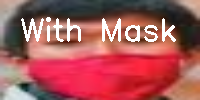

In [ ]:
frame =cv2.imread('WithMask/50.png')
frame = cv2.resize(frame,(200, 100)) 
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
cv2.putText(frame,label[0],(20,50-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
cv2_imshow(frame)

In [ ]:
cd Face\ Mask\ Dataset/Validation

/content/drive/My Drive/mask_detection/Face Mask Dataset/Validation


In [ ]:
ls

WithMask/  WithoutMask/


In [ ]:
cascade = cv2.CascadeClassifier("../../haarcascade_frontalface_default.xml")

In [ ]:
print(cascade.empty() )

False


In [ ]:
mask = "WithMask/"
plt.figure(figsize=(8,7))
label = {0:"With Mask",1:"Without Mask"}
color_label = {0: (0,255,0),1 : (0,0,255)}
cascade = cv2.CascadeClassifier("../../haarcascade_frontalface_default.xml")
count = 0
i = "WithMask/50.png"

frame =cv2.imread('WithMask/50.png')
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces = cascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    face_image = frame[y:y+h,x:x+w]
    resize_img  = cv2.resize(face_image,(150,150))
    normalized = resize_img/255.0
    reshape = np.reshape(normalized,(1,150,150,3))
    reshape = np.vstack([reshape])
    result = model.predict_classes(reshape)
    
    if result == 0:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[0],-1)
        cv2.putText(frame,label[0],(20,50-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        cv2_imshow(frame)
        break
    elif result == 1:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[1],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[1],-1)
        cv2.putText(frame,label[1],(20,50-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        cv2_imshow(frame)
        break
        
    cv2_imshow(frame)


        

<Figure size 576x504 with 0 Axes>

In [ ]:
mask = "../input/with-and-without-mask/"
plt.figure(figsize=(8,7))
label = {0:"With Mask",1:"Without Mask"}
color_label = {0: (0,255,0),1 : (0,0,255)}
cascade = cv2.CascadeClassifier("../input/frontalface/haarcascade_frontalface_default.xml")
count = 0
i = "../input/with-and-without-mask/mask1.jpg"

frame =cv2.imread(i)
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces = cascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    face_image = frame[y:y+h,x:x+w]
    resize_img  = cv2.resize(face_image,(150,150))
    normalized = resize_img/255.0
    reshape = np.reshape(normalized,(1,150,150,3))
    reshape = np.vstack([reshape])
    result = model.predict_classes(reshape)
    
    if result == 0:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[0],-1)
        cv2.putText(frame,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
    elif result == 1:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[0],-1)
        cv2.putText(frame,label[1],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
    #plt.imshow(frame)
plt.show()
cv2.destroyAllWindows()
        

error: ignored

<Figure size 576x504 with 0 Axes>

In [ ]:
mask = "../input/with-and-without-mask/"
plt.figure(figsize=(8,7))
label = {0:"With Mask",1:"Without Mask"}
color_label = {0: (0,255,0),1 : (0,0,255)}
cascade = cv2.CascadeClassifier("../input/frontalface/haarcascade_frontalface_default.xml")
count = 0
i = "../input/with-and-without-mask/mask8.jpg"

frame =cv2.imread(i)
gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
faces = cascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    face_image = frame[y:y+h,x:x+w]
    resize_img  = cv2.resize(face_image,(150,150))
    normalized = resize_img/255.0
    reshape = np.reshape(normalized,(1,150,150,3))
    reshape = np.vstack([reshape])
    result = model.predict_classes(reshape)
    
    if result == 0:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[0],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[0],-1)
        cv2.putText(frame,label[0],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
    elif result == 1:
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_label[1],3)
        cv2.rectangle(frame,(x,y-50),(x+w,y),color_label[1],-1)
        cv2.putText(frame,label[1],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
plt.show()
cv2.destroyAllWindows()
        

---

<h1 style="text-align: center;font-size: 20px;">Thanks for Reading!!</h1>

---